In [ ]:
!pip install msoffcrypto-tool

In [2]:
import pandas as pd
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
import msoffcrypto
import io
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Need to manually set project path.
fpath='/content/drive/MyDrive/Colab Notebooks/Capstone'

print(f"Project filepath, fpath: {fpath}")


file_path_censo = fpath+'/data/Comercial_Censo.csv'
file_path_metero = fpath+'/data/Comercial_Meteorología.csv'
file_path_test = fpath+'/data/Comercial_Test.csv'
file_path_ventas = fpath+'/data/Comercial_Ventas.csv'
file_path_ventas_test = fpath+'/data/Comercial_Test.csv'

data_censo = pd.read_csv(file_path_censo, delimiter=';', encoding='latin1', decimal=',',thousands='.')
data_meteoro = pd.read_csv(file_path_metero, delimiter=',', decimal=',', encoding='latin1',usecols=lambda column: column not in ['Unnamed: 0'])
data_test= pd.read_csv(file_path_test, delimiter=';', encoding='latin1')
data_ventas= pd.read_csv(file_path_ventas, delimiter=';', decimal=',', encoding='latin1')
data_ventas['sale_date']=pd.to_datetime(data_ventas['Dia'], dayfirst=True)

data_ventas_test=pd.read_csv(file_path_ventas_test, delimiter=';', decimal=',', encoding='latin1')
data_ventas_test['sale_date']=pd.to_datetime(data_ventas_test['Dia']) # not the same date format as Comercial_Ventas.csv!


Project filepath, fpath: /content/drive/MyDrive/Colab Notebooks/Capstone


### Population changes

In [5]:

# calculate proforma values for 2013-2008
cols_2013=[c for c in data_censo.columns if c<="2013"]
data_censo.loc[data_censo.Municipio=="15902 Oza-Cesuras",cols_2013]=data_censo.loc[data_censo.Municipio=="15063 Oza dos Ríos",cols_2013].values+data_censo.loc[data_censo.Municipio=="15026 Cesuras",cols_2013].values
data_censo.dropna(inplace=True,axis=0)
data_censo.set_index('Municipio',inplace=True)
data_censo=data_censo.loc[:,data_censo.columns.sort_values()]

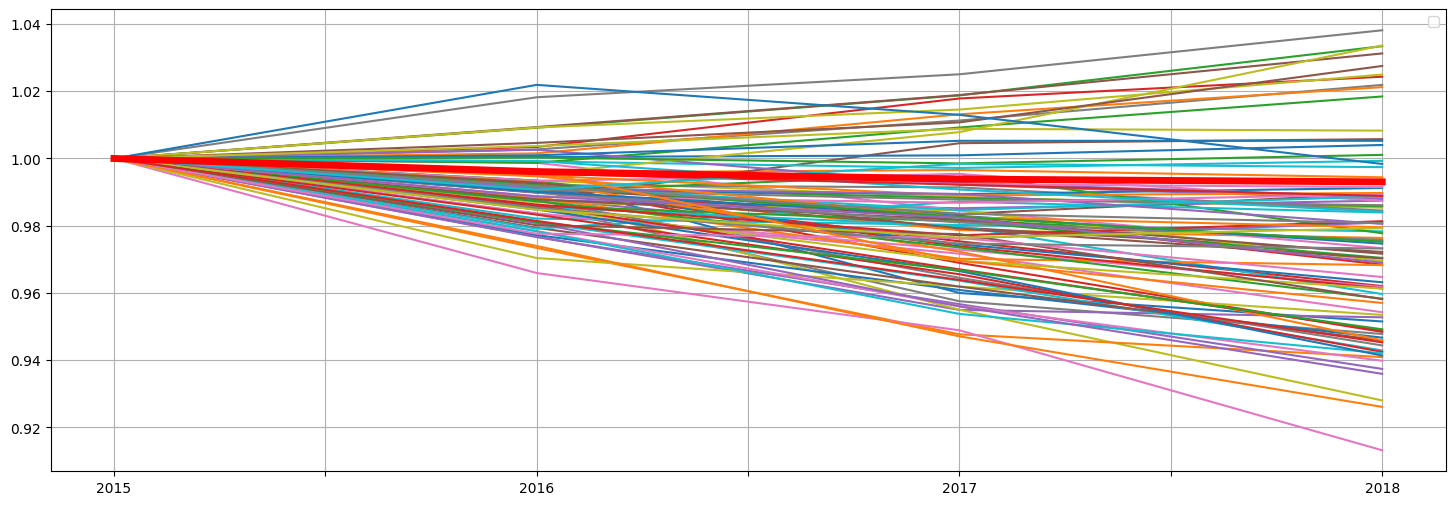

In [6]:
fig,ax=plt.subplots(1,1,figsize=(18,6))
data_censo.div(data_censo['2015'],axis=0)[[c for c in data_censo.columns if c>="2015"]].T.plot(ax=ax,grid=True)
data_censo.div(data_censo['2015'],axis=0).loc["15 Coruña, A",[c for c in data_censo.columns if c>="2015"]].T.plot(ax=ax,grid=True,color='r',lw=5,label='A Coruña')
ax.legend([])
# population change is less than 2% a year for all towns, difficult to see if that is significant for sales


In [7]:
#The excel document "Comercial_ParqueVehiculos.xlsx" is encrypted, we need to decrypt it

# Correct the file path
file_path = f'{fpath}/data/Comercial_ParqueVehiculos.xlsx'
password = "IndesIA2022!"



# Open the encrypted file
with open(file_path, "rb") as file:
    decrypted_file = io.BytesIO()
    document = msoffcrypto.OfficeFile(file)
    document.load_key(password=password)
    document.decrypt(decrypted_file)
    decrypted_file.seek(0)

# We load the data from the excel file differentiating the years
parque2016 = pd.read_excel(decrypted_file, engine='openpyxl', sheet_name=0, header=2)
decrypted_file.seek(0)  # Reset the buffer to the beginning after reading
parque2017 = pd.read_excel(decrypted_file, engine='openpyxl', sheet_name=1, header=2)
decrypted_file.seek(0)  # Reset the buffer to the beginning after reading
parque2018 = pd.read_excel(decrypted_file, engine='openpyxl', sheet_name=2, header=2)

cols_b=['PROVINCES','MUNICIPALITIES','TRUCKS','VANS','BUSES','PASSENGER CARS','MOTORCYCLES','INDUSTRIAL TRACTORS','TRAILERS & SEMI-TRAILERS','OTHER VEHICLES','TOTAL']
cols_a=['PROVINCES','MUNICIPALITIES','TRUCKS & VANS','BUSES','PASSENGER CARS','MOTORCYCLES','INDUSTRIAL TRACTORS','TRAILERS & SEMI-TRAILERS','OTHER VEHICLES','TOTAL']
parque2016.columns=cols_a
parque2017.columns=cols_b
parque2018.columns=cols_b

# Display the data to verify it was loaded correctly
parque2016['year']="2016"
parque2017['year']="2017"
parque2018['year']="2018"

parque2017['TRUCKS & VANS']=parque2017['TRUCKS']+parque2017['VANS']
parque2018['TRUCKS & VANS']=parque2018['TRUCKS']+parque2018['VANS']
parque2017.drop(columns=['TRUCKS','VANS'],inplace=True)
parque2018.drop(columns=['TRUCKS','VANS'],inplace=True)

df_autos=pd.concat((parque2016,parque2017,parque2018))
df_autos.to_pickle(fpath+'/data/df_autos.pkl')


In [9]:
# simplify the data in to two groups: Autos_motos and Trucks_other (small vs. larger vehicles and 95 vs GOA sales?)

df_autos=pd.read_pickle(fpath+'/data/df_autos.pkl')
df_autos.drop(columns=['PROVINCES'],inplace=True)
df_autos['Autos_motos']=df_autos.loc[:,[ 'PASSENGER CARS','MOTORCYCLES']].sum(axis=1)
df_autos['Trucks_other']=df_autos.loc[:,['TRUCKS & VANS','BUSES','INDUSTRIAL TRACTORS','TRAILERS & SEMI-TRAILERS','OTHER VEHICLES']].sum(axis=1)
df_autos.drop(columns=['PASSENGER CARS','MOTORCYCLES','TRUCKS & VANS','BUSES','INDUSTRIAL TRACTORS','TRAILERS & SEMI-TRAILERS','OTHER VEHICLES','TOTAL'],inplace=True)
df_autos.rename(columns={'MUNICIPALITIES':'Town'},inplace=True)
df_autos

,Town,year,Autos_motos,Trucks_other
0,Abegondo,2016,3828,807
1,Ames,2016,15316,1831
2,Aranga,2016,1291,266
3,Ares,2016,2954,253
4,Arteixo,2016,17834,3709
...,...,...,...,...
90,Vilarmaior,2018,1000,141
91,Vilasantar,2018,924,257
92,Vimianzo,2018,4876,1484
93,Zas,2018,3489,760


Text(0.5, 1.0, 'Trucks and larger vehicles')

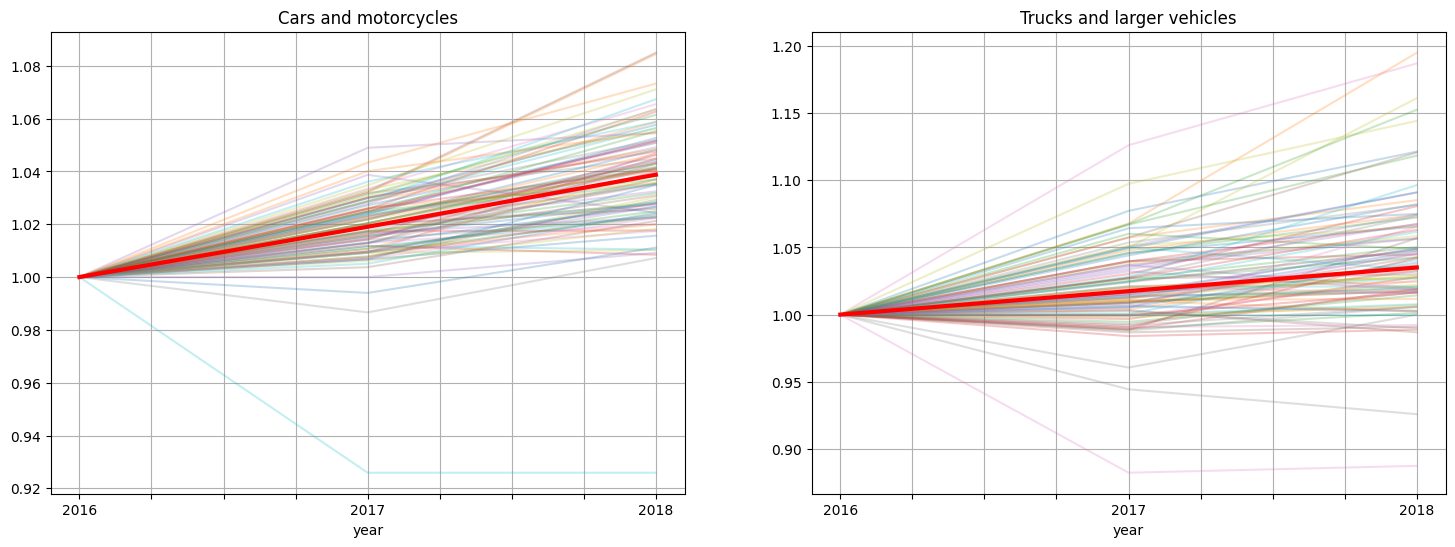

In [10]:


df_autosum=df_autos.groupby(['Town','year']).sum().unstack()
#df_autos

fig,ax=plt.subplots(1,2,figsize=(18,6))

df_autosum['Autos_motos'].div(df_autosum['Autos_motos']['2016'],axis=0).T.plot(ax=ax[0],grid=True,alpha=0.25,legend=False)
df_autosum['Autos_motos'].div(df_autosum['Autos_motos']['2016'],axis=0).loc['Total provincia'].plot(ax=ax[0],grid=True,lw=3,color='r')
#ax[0].legend(['Total'])
ax[0].set_title('Cars and motorcycles')

df_autosum['Trucks_other'].div(df_autosum['Trucks_other']['2016'],axis=0).T.plot(ax=ax[1],grid=True,alpha=0.25,legend=False)
df_autosum['Trucks_other'].div(df_autosum['Trucks_other']['2016'],axis=0).loc['Total provincia'].plot(ax=ax[1],grid=True,lw=3,color='r')
#ax[1].legend([])
ax[1].set_title('Trucks and larger vehicles')


## Cars and motorcycles vs Trucks and larger vehicles near each station (<10km)

In [11]:
# load towns with distances to stations
df_m=pd.read_pickle(fpath+'/data/df_m_wdist.pkl')

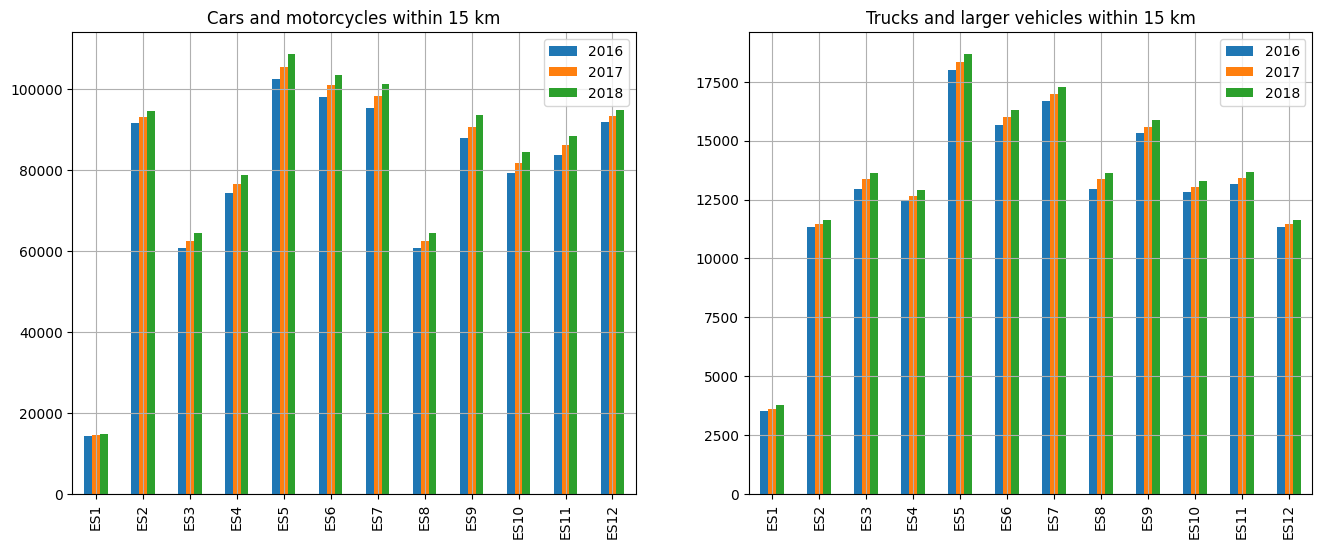

In [12]:
# Cars and motorcycles near stations
dtmp=df_autosum['Autos_motos'].reset_index().rename(columns={'2016':'2016_Autos_motos','2017':'2017_Autos_motos','2018':'2018_Autos_motos'}).set_index('Town')
dtmp=pd.merge(left=df_m.set_index('Town'),right=dtmp,left_index=True,right_index=True,how='left')

dmin=15
fig,ax=plt.subplots(1,2,figsize=(16,6))

df_autos_near_stn=pd.DataFrame(index=[f"ES{s}" for s in range(1,13)],columns=['2016','2017','2018'],
                               data=[list(dtmp.fillna(0).loc[dtmp[f"km2st{s}"]<=dmin,['2016_Autos_motos','2017_Autos_motos','2018_Autos_motos']].sum(axis=0).values) for s in range(1,13)])
df_autos_near_stn.plot.bar(title=f'Cars and motorcycles within {dmin} km',grid=True,ax=ax[0])

# Trucks and larger vehicles near stations
dtmp=df_autosum['Trucks_other'].reset_index().rename(columns={'2016':'2016_Trucks','2017':'2017_Trucks','2018':'2018_Trucks'}).set_index('Town')
dtmp=pd.merge(left=df_m.set_index('Town'),right=dtmp,left_index=True,right_index=True,how='left')

df_trucks_near_stn=pd.DataFrame(index=[f"ES{s}" for s in range(1,13)],columns=['2016','2017','2018'],
                                data=[list(dtmp.fillna(0).loc[dtmp[f"km2st{s}"]<=dmin,['2016_Trucks','2017_Trucks','2018_Trucks']].sum(axis=0).values) for s in range(1,13)])
df_trucks_near_stn.plot.bar(title=f'Trucks and larger vehicles within {dmin} km',grid=True,ax=ax[1]);



## Population Density

In [30]:
data_censo

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Municipio,,,,,,,,,,,
"15 Coruña, A",1139121.0,1145488.0,1146458.0,1147124.0,1143911.0,1138161.0,1132735.0,1127196.0,1122799.0,1120294.0,1119351.0
15001 Abegondo,5822.0,5798.0,5765.0,5709.0,5709.0,5664.0,5585.0,5586.0,5533.0,5467.0,5454.0
15002 Ames,25818.0,26983.0,27900.0,28852.0,29331.0,29689.0,29975.0,30267.0,30544.0,30835.0,31278.0
15003 Aranga,2181.0,2142.0,2126.0,2113.0,2072.0,2051.0,2033.0,1997.0,1982.0,1935.0,1894.0
15004 Ares,5682.0,5673.0,5705.0,5801.0,5839.0,5801.0,5741.0,5743.0,5672.0,5658.0,5671.0
...,...,...,...,...,...,...,...,...,...,...,...
15089 Vedra,5063.0,5059.0,5052.0,5046.0,5043.0,5008.0,5073.0,5059.0,5012.0,5051.0,5046.0
15091 Vilarmaior,1289.0,1294.0,1277.0,1273.0,1261.0,1247.0,1236.0,1233.0,1260.0,1249.0,1231.0
15090 Vilasantar,1432.0,1415.0,1406.0,1380.0,1368.0,1362.0,1316.0,1280.0,1275.0,1241.0,1225.0


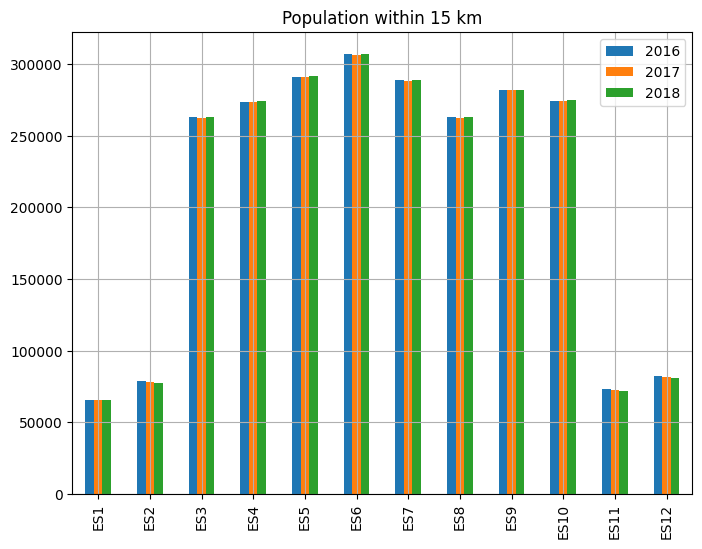

In [31]:
df_pop=data_censo.reset_index().loc[1:,['Municipio','2016','2017','2018']].rename(columns={'Municipio':'Town_long'}).copy()
#df_pop['Town2']=
df_pop['Town']=pd.DataFrame(df_pop['Town_long'].str.split(' ',n=1).to_list(),columns=['Town_no','Town'])['Town']
df_pop.drop(columns=['Town_long'],inplace=True)
df_pop.set_index('Town')
df_pop=df_pop.loc[:,['Town','2016','2017','2018']]
df_pop

dtmp=df_pop.set_index('Town')
#dtmp.index
dtmp=pd.merge(left=df_m.set_index('Town'),right=dtmp,left_index=True,right_index=True,how='left')

#dmin=15

df_pop_near_stn=pd.DataFrame(index=[f"ES{s}" for s in range(1,13)],columns=['2016','2017','2018'],
                                data=[list(dtmp.fillna(0).loc[dtmp[f"km2st{s}"]<=dmin,['2016','2017','2018']].sum(axis=0).values) for s in range(1,13)])
df_pop_near_stn.plot.bar(title=f'Population within {dmin} km',grid=True,figsize=(8,6));

<Axes: title={'center': 'GOA sales per capita'}, xlabel='Station'>

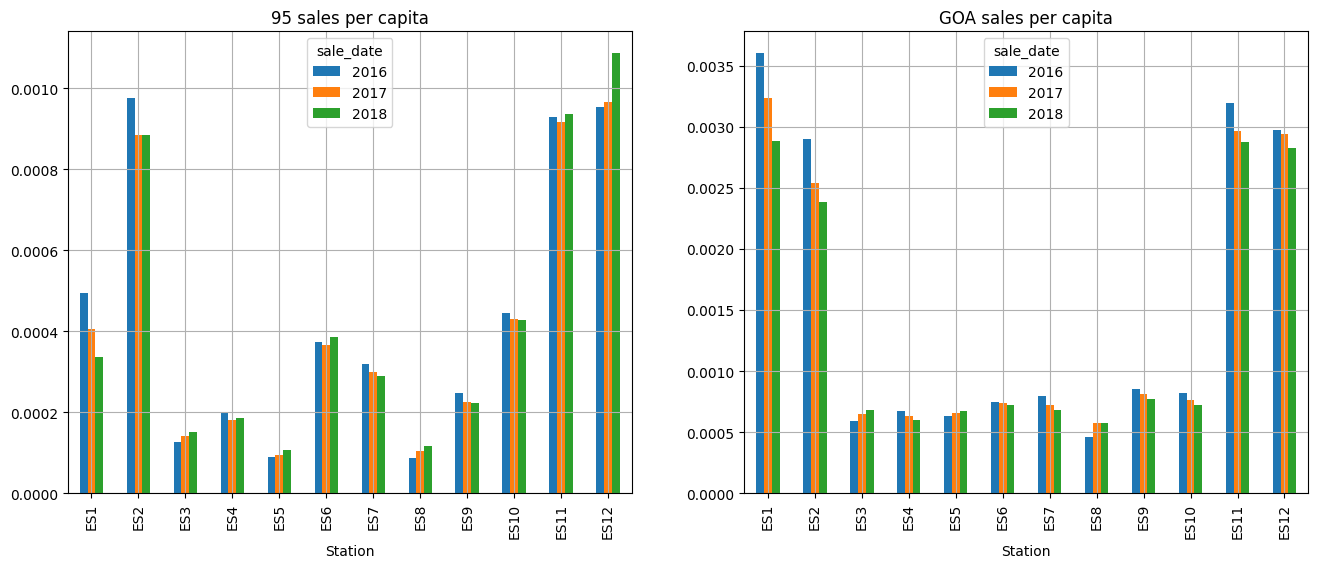

In [32]:
ddict=pd.read_pickle(fpath+'/data/df_v_m2.pkl')
df_v_m=ddict['df_v_m']
df_95sales=df_v_m.groupby(df_v_m.index.year).sum()[[f"ES{d}_95" for d in range(1,13)]].T
df_95sales['Station']=pd.DataFrame(df_95sales.reset_index()['index'].str.split('_').to_list(),columns=['Station','Type'])['Station'].values
df_95sales.set_index('Station',inplace=True)
df_95sales.rename(columns={2016:'2016',2017:'2017',2018:'2018'},inplace=True)

df_GOAsales=df_v_m.groupby(df_v_m.index.year).sum()[[f"ES{d}_GOA" for d in range(1,13)]].T
df_GOAsales['Station']=pd.DataFrame(df_GOAsales.reset_index()['index'].str.split('_').to_list(),columns=['Station','Type'])['Station'].values
df_GOAsales.set_index('Station',inplace=True)
df_GOAsales.rename(columns={2016:'2016',2017:'2017',2018:'2018'},inplace=True)


#/df_pop_near_stn
fig,ax=plt.subplots(1,2,figsize=(16,6))
df_95sales.div(df_pop_near_stn).plot.bar(title='95 sales per capita',ax=ax[0],grid=True)
df_GOAsales.div(df_pop_near_stn).plot.bar(title='GOA sales per capita',ax=ax[1],grid=True)


<Axes: title={'center': 'GOA sales per number of trucks'}, xlabel='Station'>

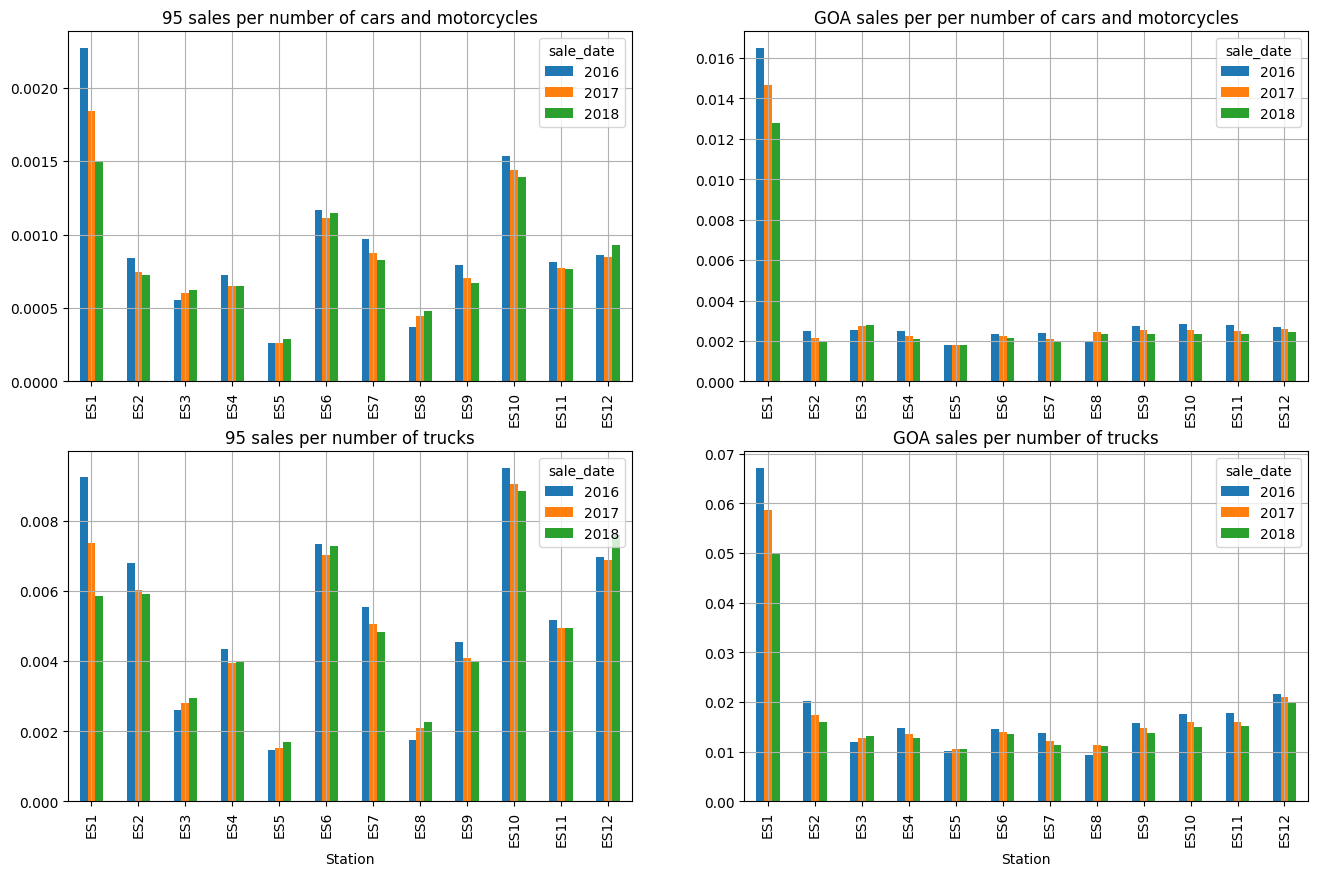

In [33]:
#df_pop_near_stn
fig,ax=plt.subplots(2,2,figsize=(16,10))
df_95sales.div(df_autos_near_stn).plot.bar(title='95 sales per number of cars and motorcycles',ax=ax[0,0],grid=True,xlabel='')
df_GOAsales.div(df_autos_near_stn).plot.bar(title='GOA sales per per number of cars and motorcycles',ax=ax[0,1],grid=True,xlabel='')

df_95sales.div(df_trucks_near_stn).plot.bar(title='95 sales per number of trucks',ax=ax[1,0],grid=True)
df_GOAsales.div(df_trucks_near_stn).plot.bar(title='GOA sales per number of trucks',ax=ax[1,1],grid=True)


### CPI Transport in Galicia from ine.es

In [34]:
# Took a look at the Transport subcomponent of CPI in Galicia.  See: https://www.ine.es/jaxiT3/Datos.htm?t=50913
# Monthly change for each month is published before middle of next month so use shift(2) in analysis
import datetime
df_tmp=pd.read_excel(f"{fpath}/data/CPI_Galicia.xlsx")
df_tmp=df_tmp.loc[(df_tmp.DataType=="MthlyChgPct")&(df_tmp.Galicia.str.strip()=="07 Transport")]
df_cpi=df_tmp.iloc[:,2:].loc[:,'2018M12':'2016M01'].rename(columns=lambda x:datetime.date(int(x.split('M')[0]),int(x.split('M')[1]),15)).sort_index(axis=1).reset_index(drop=True).T.rename(columns={0:'CPI_Transport'})
df_cpi.index=pd.to_datetime(df_cpi.index)
df_cpi.CPI_Transport=df_cpi.CPI_Transport.div(100)

df_res=pd.read_pickle(fpath+'/data/df_res_vanilla.pkl')


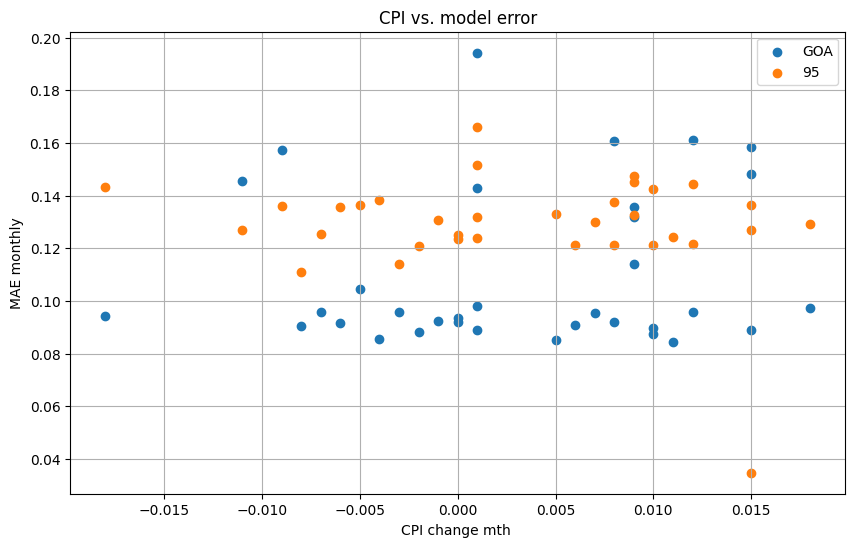

In [35]:

# Average monthly sales
AVE_95_MTHLY=data_ventas.set_index('sale_date').groupby(['Producto', pd.Grouper(freq='M')]).VentasN.sum().unstack().loc["95",:]
AVE_GOA_MTHLY=data_ventas.set_index('sale_date').groupby(['Producto', pd.Grouper(freq='M')]).VentasN.sum().unstack().loc["GOA",:]

AVE_95_RES_MTHLY=df_res.loc[:,[c for c in df_res.columns if '95' in c]].abs().sum(axis=1).groupby([pd.Grouper(freq='M')]).sum()/AVE_95_MTHLY
AVE_GOA_RES_MTHLY=df_res.loc[:,[c for c in df_res.columns if 'GOA' in c]].abs().sum(axis=1).groupby([pd.Grouper(freq='M')]).sum()/AVE_GOA_MTHLY

fig,ax=plt.subplots(1,1,figsize=(10,6))

ax.scatter(df_cpi.groupby(pd.Grouper(freq='M')).CPI_Transport.mean().shift(2),AVE_GOA_RES_MTHLY)
ax.scatter(df_cpi.groupby(pd.Grouper(freq='M')).CPI_Transport.mean().shift(2),AVE_95_RES_MTHLY)
ax.set_title('CPI vs. model error')
ax.set_xlabel('CPI change mth ')
ax.set_ylabel('MAE monthly')
ax.grid()
ax.legend(['GOA','95'])
# Need to find a monthly variable that correlates with the error to correct it

In [36]:
# No obvious relationship as PVP and has probably the same information on a daily basis
pd.concat((pd.concat((df_cpi.groupby(pd.Grouper(freq='M')).CPI_Transport.mean().shift(2),
                      AVE_GOA_RES_MTHLY),axis=1)\
           .rename(columns={0:"GOA"}),AVE_95_RES_MTHLY),axis=1)\
           .rename(columns={0:"95"}).corr()

,CPI_Transport,GOA,95
CPI_Transport,1.000000,0.107564,-0.181430
GOA,0.107564,1.000000,0.072591
95,-0.181430,0.072591,1.000000
